# The Puzzle of the Misanthropic Neighbors

Consider [this puzzle](http://fivethirtyeight.com/features/can-you-solve-the-puzzle-of-your-misanthropic-neighbors/)  from [The Riddler](http://fivethirtyeight.com/tag/the-riddler/):
    
> *The misanthropes are coming. Suppose there is a row of some number, N, of houses in a new, initially empty development. Misanthropes are moving into the development one at a time and selecting a house at random from those that have nobody in them and nobody living next door. They keep on coming until no acceptable houses remain. At most, one out of two houses will be occupied; at least one out of three houses will be. But what’s the expected fraction of occupied houses as the development gets larger, that is, as N goes to infinity?*

# Consider *N*=4 Houses

![N houses](http://www.publicdomainpictures.net/pictures/180000/nahled/street-doodle.jpg)

To make sure we understand the problem, let's try a simple example, with *N*=4 houses. We will represent the  originally empty row of four houses by four dots:

     ....
     
Now the first person chooses one of the four houses (which are all acceptable). We'll indicate an occupied house by a `1`, so the four equiprobable choices are:

     Choice 0: 1...
     Choice 1: .1..
     Choice 2: ..1.
     Choice 3: ...1
     
When a house is occupied, any adjacent houses become unacceptable. We'll indicate that with a `0`:

     Choice 0: 10..
     Choice 1: 010.
     Choice 2: .010
     Choice 3: ..01
     
In all four cases, a second occupant has a place to move in, but then there is no place for a third occupant. 
The occupancy is 2 in all cases, and thus the *expected occpancy* is 2. The occupancy fraction, or *density*, is 2/*N* = 2/4 = 1/2.
     

# Consider *N*=7 Houses

With *N*=7 houses, there are 7 equiprobable choices for the first occupant:

     Choice 0: 10.....
     Choice 1: 010....
     Choice 2: .010...
     Choice 3: ..010..
     Choice 4: ...010.
     Choice 5: ....010
     Choice 6: .....01
     
Now we'll add something new: the lengths of the **runs** of consecutive acceptable houses to the left and right of the chosen house:

     Choice 0: 10..... runs = (0, 5)
     Choice 1: 010.... runs = (0, 4)
     Choice 2: .010... runs = (1, 3) 
     Choice 3: ..010.. runs = (2, 2) 
     Choice 4: ...010. runs = (3, 1) 
     Choice 5: ....010 runs = (4, 0) 
     Choice 6: .....01 runs = (5, 0) 
     
# Defining `occ(n)`

This gives me a key hint as to how to analyze the problem. I'll define `occ(n)` to be the expected number of occupied houses in a row of `n` houses. So:

     Choice 0: 10..... runs = (0, 5); occupancy = occ(0) + 1 + occ(5)
     Choice 1: 010.... runs = (0, 4); occupancy = occ(0) + 1 + occ(4)
     Choice 2: .010... runs = (1, 3); occupancy = occ(1) + 1 + occ(3)
     Choice 3: ..010.. runs = (2, 2); occupancy = occ(2) + 1 + occ(2)
     Choice 4: ...010. runs = (3, 1); occupancy = occ(3) + 1 + occ(1)
     Choice 5: ....010 runs = (4, 0); occupancy = occ(4) + 1 + occ(0)
     Choice 6: .....01 runs = (5, 0); occupancy = occ(5) + 1 + occ(0)     
     
So we can say that `occ(n)` is:

- 0 when `n` is 0 (because no houses means no occupants),
- 1 when `n` is 1 (because one isolated acceptable house has one occupant),
- else the mean, over the `n` choices for the first occupied house,
of the sum of that house plus the occupancy of the runs to the left and right.

We can implement that:

In [1]:
from statistics import mean

def occ(n):
    "The expected occupancy for a row of n houses (under misanthrope rules)."
    return (0 if n == 0 else
            1 if n == 1 else
            mean(occ(L) + 1 + occ(R)
                 for (L, R) in runs(n)))

def runs(n):
    """A list [(L, R), ...] where the i-th tuple contains the lengths of the runs
    of acceptable houses to the left and right of house i."""
    return [(max(0, i - 1), max(0, n - i - 2))
            for i in range(n)]

def density(n): return occ(n) / n

Let's check that `occ(4)` is 2, as we computed it should be, and for other small values, up to 7:

In [2]:
{n: occ(n) for n in range(8)}

{0: 0,
 1: 1,
 2: 1,
 3: 1.6666666666666667,
 4: 2,
 5: 2.466666666666667,
 6: 2.888888888888889,
 7: 3.323809523809524}

That looks good, although I can't prove the value above 4 are ccorrect. Now check that `runs(7)` is what we described above:

In [3]:
runs(7)

[(0, 5), (0, 4), (1, 3), (2, 2), (3, 1), (4, 0), (5, 0)]

# Dynamic Programming Version of `occ`

The computation of `occ(n)` makes multiple calls to `occ(n-1), occ(n-2),` etc. To avoid re-computing the same calls over and over, we will modify `occ` to save previous results using [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming). I could implement that in one line with the decorator [`@functools.lru_cache`](https://docs.python.org/3/library/functools.html#functools.lru_cache), but then I would have to worry about the recursion limit. Instead I will explicitly manage a list, `cache`, such that `cache[n]` holds `occ(n)`:

In [4]:
def occ(n, cache=[0, 1]):
    "The expected occupancy for a row of n houses (under misanthrope rules)."
    # Store occ(i) in cache[i] for all as-yet-uncomputed values of i up to n:
    for i in range(len(cache), n+1):
        cache.append(mean(cache[L] + 1 + cache[R]
                          for (L, R) in runs(i)))
    return cache[n]

Let's make sure this new version gets the same results as the old version:

In [5]:
occ(4) == 2

True

In [6]:
occ(7)

3.323809523809524

Let's make sure the caching makes computation pretty fast the first time, and *very* fast the second time:

In [7]:
%time occ(2000)

CPU times: user 2.68 s, sys: 13.5 ms, total: 2.7 s
Wall time: 2.71 s


864.9617138385324

In [8]:
%time occ(2000)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.01 µs


864.9617138385324

# Plotting `density(n)`

To get a feel for the limit of `density(n)`, start by drawing a plot over some small values of `n`:

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def plot_density(ns):
    "Plot density(n) for each n in the list of numbers ns."
    plt.xlabel('n houses'); plt.ylabel('density(n)')
    plt.plot(ns, [density(n) for n in ns], 's-')
    return density(ns[-1])

0.4353323288377046

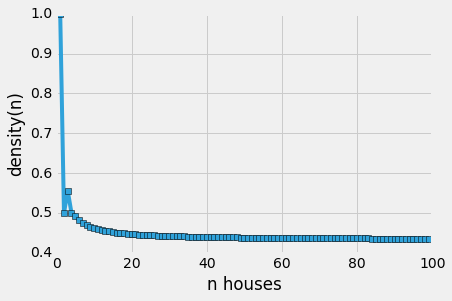

In [10]:
plot_density(range(1, 100))

There is something funny going on with the first few values of `n`. Let's separately look at the first few:

0.46203174603174607

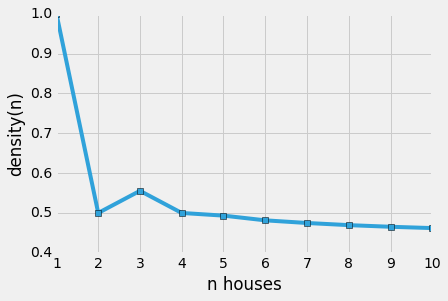

In [11]:
plot_density(range(1, 11))

And at a wider range:

0.43240754751464183

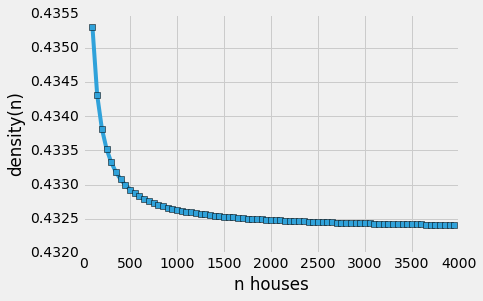

In [12]:
plot_density(range(100, 4000, 50))

The density is going down, and the curve is almost but not quite flat. 



# lim <sub>n &rarr; &infin;</sub> density(n)

[The puzzle](http://fivethirtyeight.com/features/can-you-solve-the-puzzle-of-your-misanthropic-neighbors/)
is to figure out the limit of `density(n)` as `n` goes to infinity. The plot above makes it look like  0.432+something, but we can't answer the question just by plotting;  we'll need to switch modes from *computational* thinking to *mathematical* thinking.

At this point I started playing around with `density(n)`, looking at various values, differences of values, ratios of values, and ratios of differences of values, hoping to achieve some mathematical insight. Mostly I got dead ends.
But eventually I hit on something promising. I looked at the difference between density values (using the function `diff`), and particularly the difference as you double `n`:

In [13]:
def diff(n, m): return density(n) - density(m)

diff(100, 200)

0.0014849853757253895

And compared that to the difference when you double `n` again:

In [14]:
diff(200, 400)

0.0007424926878626947

Hmm&mdash;I noticed that the first difference is just about twice as much as the second. Let's check:

In [15]:
diff(100, 200) / diff(200, 400)

2.0

Wow&mdash;not only is it *close* to twice as much, it is *exactly* twice as much (to the precision of floating point numbers). Let's try other starting values for `n`:

In [16]:
n = 250; diff(n, 2*n) / diff(2*n, 4*n)

2.0

In [17]:
n = 500; diff(n, 2*n) / diff(2*n, 4*n)

2.0

OK, I'm convinced this is real! 

Now, what mathematical function behaves like this? I figured out that *f*(*n*) = (1 / *n*) does. The ratio of the differences would be:

$$\frac{f(n) - f(2n)}{f(2n) - f(4n)} = \frac{1/n - 1/(2n)}{1/(2n) - 1 / (4n)}\;\;$$

Multiplying top and bottom by *n* you get:


$$\frac{1 - 1/2}{1/2 - 1 /4} = \frac{1/2}{1/4} = 2\;\;$$

If the function (1 / *n*) fits the pattern, then so does any *affine transformation* of (1 / *n*), because we are taking the ratio of differences.  So that means a density function of the form

    density(n) = A + B / n 
    
would fit the patterm.  I can try a `scipy.optimize.curve_fit` to estimate the parameters *A* and *B*:

In [18]:
from scipy.optimize import curve_fit

Ns = list(range(100, 5001, 100))

def f(n, A, B): return A + B / n

((A, B), covariance) = curve_fit(f=f, xdata=Ns, ydata=[density(n) for n in Ns])

covariance

array([[  4.70916321e-33,  -1.30373854e-30],
       [ -1.30373854e-30,   1.44885627e-27]])

The `curve_fit` function returns a sequence of parameter values, and a covariance matrix. The fact that all the numbers in the covariance matrix are really small indicates that the parameters are a really good fit.  Here are the parameters, `A` and `B`:

In [19]:
A, B

(0.43233235838169332, 0.29699707514503415)

We can plug them into a function that estimates the density:

In [20]:
def estimated_density(n): return A + B / n

And we can test how close this function is to the true `density` function:

In [21]:
max(abs(density(n) - estimated_density(n))
    for n in range(200, 4000))

6.106226635438361e-16

That says that, for all values of `n` from 200 to 4,000, `density(n)` and `estimated_density(n)` agree at least through the first 15 decimal places!

We now have a plausible answer to the puzzle:

> lim<sub style="font-size:large"> <tt>n</tt>&rarr;&infin;</sub> <tt>density(n) &cong; A = 0.43233235838169</tt>

# Why?

Theis answer is empirically strong (15 decimal places of accuracy) but theoretically weak: we don't have a **proof**, and we don't have an explanation for **why** the density function has this form. We need some more mathematical thinking. 

I didn't have any ideas, so I looked to see if anyone else had written something about the number 0.432332358169 I tried several searches and found two interesting formulas:

- Search: [`[0.4323323]`](https://www.google.com/search?q=0.4323323) Formula: `sinh(1) / exp(1)` [(Page)](http://arxiv.org/pdf/1310.4360.pdf)
- Search: [`[0.432332358]`](https://www.google.com/search?q=0.432332358) Formula: `0.5(1-e^(-2))` [(Page)](http://www.actuarialoutpost.com/actuarial_discussion_forum/archive/index.php/t-52095.html)

I can verify that the two formulas are equivalent, and that they are indeed equal to `A` to at least 15 decimal places:

In [22]:
from math import sinh, exp, e

S = sinh(1) / exp(1)
E = 0.5 * (1 - e ** (-2))

S, E, A

(0.43233235838169365, 0.43233235838169365, 0.43233235838169332)

So I now have a suspicion that

> lim <sub>n &rarr; &infin;</sub> density(n) = (1 - e<sup>-2</sup>) / 2

but I still have no proof, nor any intuition as to why this is so.

# John Lamping to the Rescue

I reported my results to Anne Paulson and John Lamping, who had originally related the problem to me, and the next day John wrote back with the following:

<blockquote>
I got a derivation of the formula!

<p>Suppose that each house has a different "attractiveness", and that when it is a misanthrope's turn to pick a house, they consider the houses in order, from most attractive to least, and pick the first house not next to any other house. If the attractiveness are chosen independently, this process gives the same probabilities as each misanthrope picking from the available houses randomly.

<p>To be more concrete, let the attractivenesses range from 0 to 1 with uniform probability, with lower numbers being being considered earlier, and hence more attractive. (This makes the math come out easier.)

<p>Given the attractiveness, a, of a house, we can compute the chance that it will end up getting picked. It will get picked if and only if neither house on either side gets considered earlier and gets picked. Lets consider one side, and assume the houses, and their attractivenesses, are labeled a, b, c, d, e, f, g, ... with the house we are considering being a. There are an infinite number of cases where b won't get considered before a and picked. Here are the first few:

<p>   a < b  (a is considered before b)
<p>   a > b > c < d  (Someone considered c first among these 4 and picked it. A later person considered b before a, but rejected it because c had already been chosen.)
<p>   a > b > c > d > e < f (Someone considered e first among these 6, and picked it. A later person considered d, but rejected it because e was chosen, then considered c, which they picked. Still later, someone considered b, which they rejected because c had been chosen.)

<p>We can write down the probabilities of these cases as a function of the attractiveness of a:

<p>   a < b: The chance that b is greater than a: 1 - a.
<p>   a > b > c < d: Let y = a - c, so y is between 0 and a. The probability is the integral over the possible y of the chance that b is between a and c, times the chance that d is greater than c, or integral from 0 to a of y * (1 - a + y) dy.
<p>   a > b > c > d > e < f: Let y = a - e. The probability is the integral of (the chance that b, c, and d are all between a and e, and ordered right, which is y^3 / 3!, times the chance that f is greater than e, which is (1 - a + y))

<p>If you work out the definite integrals, you get

<p>   a < b: 1 - a
<p>   a > b > c < d: a^2 / 2 - a^3 / 3!
<p>   a > b > c > d > e < f: a^4 / 4! - a^5 / 5!

<p>Add them all up, and you have 1 - a + a^2 / 2 - a^3 / 3! + a ^4 / 4! ... the Taylor expansion for e^-a. 

<p>Now, there will be a house at a if both adjacent houses are not picked earlier, so the chance is the square of the chance for one side: e^(-2a). Integrate that from 0 to 1, and you get 1/2 (1 - e^-2).
</blockquote>

You can compare John Lamping's solution to the solutions by [Jim Ferry](http://fivethirtyeight.com/features/the-perplexing-puzzle-of-the-proud-partygoers/) and [Andrew Mascioli](http://andrewmascioli.com/index.php/2016/04/24/the-misanthropic-neighborhood/). 

# Styles of Thinking

It is clear that different write-ups of this problem display different styles of thinking. I'll attempt to name and describe them:

- **Mathematical Publication Style**: This style uses sophisticated mathematics (e.g. generating functions, differentiation, asymptotic analysis, and manipulation of summations). It defines new abstractions without
necessarily trying to motivate them first, it is terse and formal, and it gets us to the conclusion in a way that is
clearly correct, but does not describe all the steps of how the author came up with the ideas. (Ferry and Mascioli)
- **Mathematical Exploration Style**: Like the Mathematical Publication Style, but with more explanatory prose. (Lamping)
- **Computational Thinking**: A more concrete style; tends to use programs with specific values of `n` rather than 
creating a proof for all values of `n`; produces tables or plots to help guide intuition; verifies results
with tests or alternative implementations. (Norvig)

In this specific puzzle, my steps were:
- Analyze the problem and implement code to solve it for small values of `n`.
- Plot results and examine them for insight.
- Play with the results and get a guess at a partial solution <tt>density(n) &cong; A + B / n</tt>.
- Solve numerically for `A` and `B`.
- Do a search with the numeric value of `A` to find a formula with that value.
- Given that formula, let Lamping figure out how it corresponds to the problem.

This is mostly  computational thinking, with a little mathematical thrown in. 


# Validation by Anticipating Objections

Is our implementation of `occ(n)` correct? I think it is, but I can anticipate some objections and answer them:

- *In `occ(n)`, is it ok to start from all empty houses, rather than considering layouts of partially-occupied houses?* Yes, because the problem states that initially all houses are empty, and each choice of a house breaks the street up into runs of acceptable houses, flanked by unacceptable houses. If we get the computation right for a run of `n` acceptable houses, then we can get the whole answer right. A key point is that the chosen first house breaks the row of houses into 2 runs of *acceptable* houses, not 2 runs of *unoccupied* houses. If it were unoccupied houses, then we would have to also keep track of whether there were occupied houses to the right and/or left of the runs. By considering runs of acceptable houses, eveything is clean and simple.

- *In `occ(7)`, if the first house chosen is 2, that breaks the street up into runs of 1 and 3 acceptable houses. There is only one way to occupy the 1 house, but there are several ways to occupy the 3 houses. Shouldn't the average give more weight to the 3 houses, since there are more possibilities there?* No. We are calculating occupancy, and there is a specific number (5/3) which is the expected occupancy of 3 houses; it doesn't matter if there is one combination or a million combinations that contribute to that expected value, all that matters is what the expected value is.




# Validation by Simulation


A simulation can add credence to our implementation of `density(n)`, for two reasons:
- The code for the simulation can  have a more direct correspondance to the problem statement.
- When two very different implementations get the same result, that is evidence supporting both of them.


The simulation will start with an empty set of occupied houses. We then go through the houses in random order, occupying just the ones that have no neighbor. (Note that `random.sample(range(n), n)` gives a random ordering of `range(n)`.)

In [23]:
import random

def simulate(n):
    "Simulate moving in to houses, and return a sorted tuple of occupied houses."
    occupied = set()
    for house in random.sample(range(n), n):
        if (house - 1) not in occupied and (house + 1) not in occupied:
            occupied.add(house)
    return sorted(occupied)

def simulated_density(n, repeat=10000):
    "Estimate density by simulation, repeated `repeat` times."
    return mean(len(simulate(n)) / n 
                for _ in range(repeat))

Let's see if the simulation returns results that match the actual `density` function and the `estimated_density` function:

In [24]:
print('   n   simulate  density   estimated')
for n in (10, 25, 50, 100, 200, 400):
    print('{:4d}   {:.4f}    {:.4f}    {:.4f}'
          .format(n, simulated_density(n), density(n), estimated_density(n)))

   n   simulate  density   estimated
  10   0.4621    0.4620    0.4620
  25   0.4442    0.4442    0.4442
  50   0.4383    0.4383    0.4383
 100   0.4354    0.4353    0.4353
 200   0.4339    0.4338    0.4338
 400   0.4331    0.4331    0.4331


We get good agreement (at least to 3 decimal places), suggesting that either our three implementations are all correct, or we've made  mistakes in all three. 

The `simulate` function can also give us insights when we look at the results it produces:

In [25]:
simulate(7)

[0, 2, 4, 6]

Let's repeat that multiple times, and store the results in a `Counter`, which tracks how many times it has seen each result:

In [26]:
from collections import Counter

Counter(tuple(simulate(7)) for _ in range(10000))

Counter({(0, 2, 4, 6): 3220,
         (0, 2, 5): 1214,
         (0, 3, 5): 1029,
         (0, 3, 6): 827,
         (1, 3, 5): 1417,
         (1, 3, 6): 976,
         (1, 4, 6): 1317})

That says that about 1/3 of the time, things work out so that the 4 even-numbered houses are occupied. But if anybody ever chooses an odd-numbered house, then we are destined to have 3 houses occupied (in one of 6 different ways, of which (1, 3 5) is the most common, probably because it is the only one that has three chances of getting started with an odd-numbered house).

# Verification by Test

Another way to gain more confidence in the code is to run a test suite:

In [27]:
def test():
    assert occ(0) == 0
    assert occ(1) == occ(2) == 1
    assert occ(3) == 5/3
    assert density(3) == occ(3) / 3
    assert density(100) == occ(100) / 100
    assert runs(3) == [(0, 1), (0, 0), (1, 0)]
    assert runs(7) == [(0, 5), (0, 4), (1, 3), (2, 2), (3, 1), (4, 0), (5, 0)]
    for n in (3, 7, 10, 20, 100, 101, 200, 201):
        for repeat in range(500):
            assert_valid(simulate(n), n)         
    return 'ok'

def assert_valid(occupied, n):
    """Assert that, in this collection of occupied houses, no house is adjacent to an
    occupied house, and every unoccupied position is adjacent to an occupied house."""
    occupied = set(occupied) # coerce to set
    for house in range(n):
        if house in occupied:
            assert not ((house - 1) in occupied or (house + 1) in occupied)
        else:
            assert      (house - 1) in occupied or (house + 1) in occupied

test()

'ok'

# Conclusion

I'm happy with my result:

> <tt>lim <sub>n &rarr; &infin;</sub> density(n) = (1 - e<sup>-2</sup>) / 2 &cong; 0.43233235838169365 </tt>

I got the fun of working on the puzzle, the satisfaction of seeing John Lamping work out a proof, and the awe of seeing the mathematically sophisticated solutions of Jim Ferry and Andrew Mascioli, solutions that I know I could never come up with, but that I could get near to by coming at the problem with a different style of thinking.